In [5]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import scipy.stats

In [6]:
# Demo:  gaussian mixture model for one-dimensional data;
# find maximum-likelihood parameters by writing a loss function
# and optimizing it.
# Examine simple 1d classifier for this 1d dataset.

In [7]:
# Here I load in a much-loved dataset from 1888, Francis Galton's heights of 900
# adults and their parents.

galton = pd.read_csv("../data/galton.csv")
galton.head()
y = galton.childHeight.values

In [8]:
galton.head()

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,78.5,67.0,75.43,4,1,male,73.2
1,1,78.5,67.0,75.43,4,2,female,69.2
2,1,78.5,67.0,75.43,4,3,female,69.0
3,1,78.5,67.0,75.43,4,4,female,69.0
4,2,75.5,66.5,73.66,4,1,male,73.5


In [9]:
galton.family.value_counts()

185    15
166    11
120    11
66     11
130    11
       ..
41      1
171     1
34      1
30      1
157     1
Name: family, Length: 205, dtype: int64

Text(0, 0.5, 'Number')

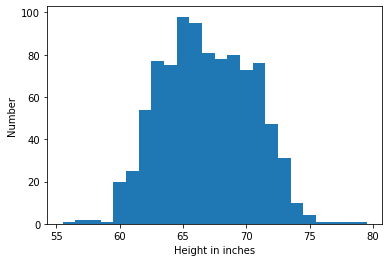

In [10]:
plt.hist(galton.childHeight, bins=np.arange(55, 80) + .5) 
plt.xlabel("Height in inches")
plt.ylabel("Number")

To make sure I can use optimization, let's try a test.

$$ LOSS_{SSE}(\theta; y)  = \sum (y-\theta)^2 $$

$$ \hat{\theta} = argmin_{\theta} \ \  LOSS_{SSE} (\theta; y) $$

If I wanted to replace all my y with a constant,
what number gives me the smallest summed error?



In [11]:
# Here I define an extremely simple function.
# This function sums the squared-differences between
# each value in y and the paramter theta.
def LOSS_SSE( theta ):
    assert len(theta) == 1
    return np.sum( (y - theta)**2 ) 

In [12]:
LOSS_SSE([64]) , LOSS_SSE([65]), LOSS_SSE([67]),  LOSS_SSE([68]),  LOSS_SSE([69])

(18995.190000000002, 14799.79, 12012.99, 13421.59, 16698.19)

In [13]:
thetahat = minimize(LOSS_SSE, 0)
thetahat

      fun: 11952.69953961456
 hess_inv: array([[0.00052716]])
      jac: array([0.00012207])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 106
      nit: 4
     njev: 47
   status: 2
  success: False
        x: array([66.74593149])

Declare victory, the value 66.75 inches minimizes the sum-squared differences from all 946 data points.

In [18]:
y

array([73.2, 69.2, 69. , 69. , 73.5, 72.5, 65.5, 65.5, 71. , 68. , 70.5,
       68.5, 67. , 64.5, 63. , 72. , 69. , 68. , 66.5, 62.5, 62.5, 69.5,
       76.5, 74. , 73. , 73. , 70.5, 64. , 70.5, 68. , 66. , 66. , 65.5,
       74. , 70. , 68. , 67. , 67. , 66. , 63.5, 63. , 65. , 71. , 62. ,
       68. , 67. , 71. , 70.5, 66.7, 72. , 70.5, 70.2, 70.2, 69.2, 68.7,
       66.5, 64.5, 63.5, 74. , 73. , 71.5, 62.5, 66.5, 62.3, 66. , 64.5,
       64. , 62.7, 73.2, 73. , 72.7, 70. , 69. , 68.5, 68. , 66. , 73. ,
       68.5, 68. , 73. , 71. , 67. , 74.2, 70.5, 69.5, 66. , 65.5, 65. ,
       65. , 65.5, 66. , 63. , 70.5, 70.5, 69. , 65. , 63. , 69. , 67. ,
       63. , 73. , 67. , 70.5, 70. , 66.5, 63. , 67.5, 67.2, 66.7, 64. ,
       71. , 70. , 70. , 66. , 65. , 65. , 74. , 72. , 69. , 67.5, 63.5,
       72. , 71.5, 71.5, 70. , 68. , 65.7, 78. , 74. , 73. , 72. , 67. ,
       73.2, 73. , 69. , 67. , 70. , 67. , 67. , 66.5, 70. , 69. , 68.5,
       66. , 64.5, 63. , 71. , 67. , 76. , 72. , 71

In [19]:
# A slightly more elaborate model: normal 
def LOSS_NORMAL(parameter):
    return np.sum( -scipy.stats.norm.logpdf( y, loc=parameter[0], scale=parameter[1])  )  

In [20]:
LOSS_NORMAL([66.7,3.5]), LOSS_NORMAL([66.7,4.5]), LOSS_NORMAL([66.7,5.5]), LOSS_NORMAL([66.7,8.5]), 

(2516.314916873552, 2558.2739156392413, 2648.121159403523, 2939.8416669954977)

In [21]:
# Does it look like it has a minimum ? 
LOSS_NORMAL([86.7,3.5]), LOSS_NORMAL([66.7,3.5]), LOSS_NORMAL([46.7,3.5])

(17695.25369238376, 2516.314916873552, 17835.335325036813)

In [22]:
# Run library optimization function
minimize(LOSS_NORMAL, [66, 3.5], method="BFGS")

      fun: 2515.781800385769
 hess_inv: array([[0.07772882, 0.04119342],
       [0.04119342, 0.02304153]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([66.7459315 ,  3.57733453])

Declare victory, now we have a mean and standard deviation that maximize the likelihood
of the data given a normal distribution with location, scale parameters 66.745 and 3.577.

Wait just one minute.

In [23]:
y.mean(), y.std()

(66.74593147751605, 3.5773346010057634)

In [ ]:
# Hmm. Right.  I have used a machine gun to shoot a squirrel.

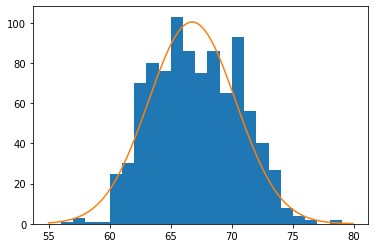

In [24]:
# Plot the Normal distribution fit and the data histogram:
x = np.arange(55,80,.1)
yhat_g = scipy.stats.norm.pdf(x, loc=66.7459, scale=3.577)
plt.hist(y, bins=np.arange(55, 80))
plt.plot(x,yhat_g *900)

To get some insight into this likelihood function, 
$$ \textrm{norm.logpdf}(x, mu, sigma) = c -  \log \sigma + {(x - \mu)^2 \over 2 \sigma^2} $$
Let's evaluate it on a 2d grid in $\mu$ and $\sigma$ and make contour plots:


In [25]:
# This is going to evaluate our LOSS_NORMAL function on a grid
xgrid = np.arange(55,80,2) 
ygrid = np.arange(0.5, 20.0, 0.5)
xax, yax = np.meshgrid(xgrid, ygrid, indexing="ij")
z = np.zeros(xax.shape)
print(xax.shape, yax.shape, z.shape)
for i in range(len(xgrid)):
    for j in range(len(ygrid)):
        z[i,j]= LOSS_NORMAL((xgrid[i], ygrid[j]))


(13, 39) (13, 39) (13, 39)


In [ ]:
# Arright, I can't find how to plot the axes right without plt.contour and plt.contourf

Text(0, 0.5, 'posterior std')

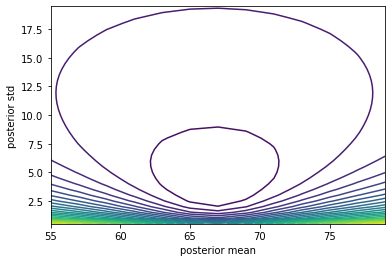

In [28]:
plt.contour(xax, yax, np.log(z), levels=30)
plt.xlabel("posterior mean")

plt.ylabel("posterior std")


In [ ]:
# It has an optimum.  (This is good.)

You didn't really need a loss function to find mean and standard deviation of a
collection of points.  

Now consider this model:

$$ P(x, \mu_1, \sigma_1, \mu_2, \sigma_2) = {1\over 2} \mathcal{N} (x; \mu_1, \sigma_1) + 
{1\over 2} \mathcal{N} (x; \mu_2, \sigma_2)  $$

This is a mixture of two Gaussian distributions.

In [29]:
# So we construct the sum over all the data points of the log of two normal pdfs:

def LOSS_NORMAL2(parameter2):
    '''Sums likelihoods over y (assumed already defined) 
    for sum-of-two-equally-weighted-normal-distributions
    with paramters mu_1, sigma_1, mu_2, and sigma_2.'''
    assert len(parameter2) ==4  # throw an error if parameter2 has the wrong type
    return np.sum( -np.log(
                           scipy.stats.norm.pdf( y, loc=parameter2[0], scale=parameter2[1]) +
                           scipy.stats.norm.pdf( y, loc=parameter2[2], scale=parameter2[3]) ))  

In [30]:
LOSS_NORMAL2([60,3.5,70,3.5])
    

2189.586119511434

In [31]:
# Just to convince myself the sign is right.. 
LOSS_NORMAL2([0,3.5,70,3.5]), LOSS_NORMAL2([60,3.5,70,3.5]), LOSS_NORMAL2([120,3.5,70,3.5])


(2919.91165156743, 2189.586119511434, 2919.91165156743)

In [32]:
minimize(LOSS_NORMAL2, [63, 2, 70, 2], method="BFGS")

      fun: 1851.8674514407735
 hess_inv: array([[ 0.00783133,  0.01133038, -0.00259784,  0.0187608 ],
       [ 0.01133038,  0.02768016, -0.00456697,  0.0397389 ],
       [-0.00259784, -0.00456697,  0.00387407, -0.01253936],
       [ 0.0187608 ,  0.0397389 , -0.01253936,  0.07293249]])
      jac: array([ 0.00000000e+00, -1.52587891e-05,  1.52587891e-05,  0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 105
      nit: 15
     njev: 21
   status: 2
  success: False
        x: array([64.08472207,  2.2771205 , 69.42351661,  2.48216295])

In [33]:
# And now evaluate this on a grid of len(xgrid2)x len(ygrid2) to make a contour plot
xgrid2 = np.arange(55,80,2) 
ygrid2 = np.arange(55,80,2)
xax2, yax2 = np.meshgrid(xgrid2, ygrid2, indexing="ij")
z2 = np.zeros(xax2.shape)
print(xax2.shape, yax2.shape, z.shape)
for i in range(len(xgrid2)):
    for j in range(len(ygrid2)):
        z2[i,j]= LOSS_NORMAL2((xgrid2[i],2.27,  ygrid2[j], 2.48))


(13, 13) (13, 13) (13, 39)


array([[55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79]])

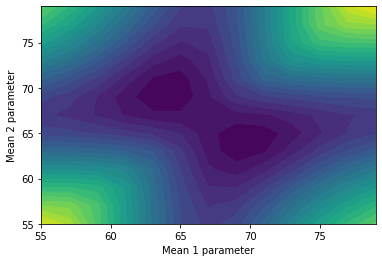

In [34]:
plt.contourf(xax2, yax2, np.log(z2), levels=30)
plt.xlabel("Mean 1 parameter")
plt.ylabel("Mean 2 parameter")
yax2

In [ ]:
# This is, believe it or not, reassuring.  There are two equal 
# optima, one with mean1 = 69 and mean2 = 64, and one with 
# mean1 = 64 and mean2 = 69; these correspond to switching the 
# labels between the large and the small groups.

Some questions for thought:  

* The optimizer claimed victory after only 105 evaluations of the loss function.  How many times did I evaluate the loss function to make these contour maps?

* The parameter space for my function was (mean1, std1, mean2, std2), that's four dimensions.
I plotted a two-dimensional slice, with std1 and std2 held fixed at their optmimum values.
Do you think std1 and std1 might be correlated with mean1 and mean2?

* There were two paramters (sigma_1 and sigma_2) that were .. "similar."   mean_1 and mean_2 were similar, but it was clear they would chase down different parts of the distribution.  But what does it mean if sigma_1 and sigma_2 are very different?   What would happen to the fitting process if I set sigma_2 = sigma_1 ? 

* There was one paramter that I failed to parameterize: the mixing coefficient.  In constructing the loss function I implicitly made the weights for normal 1 and normal 2 equal.    Would I get a better or worse fit if I let the algorithm fit the probability ratio between class 1 and class 2?



In [37]:
# One more contour plotl this one looking at mean_1 and sigma_1 while
# the values of mean_2 and sigma_2 are kept fixed.
xgrid3 = np.arange(55,80,1) 
ygrid3 = np.arange(0.5,20,0.25)
xax3, yax3 = np.meshgrid(xgrid3, ygrid3, indexing="ij")
z3 = np.zeros(xax3.shape)
print(xax3.shape, yax3.shape, z.shape)
for i in range(len(xgrid3)):
    for j in range(len(ygrid3)):
        z3[i,j]= LOSS_NORMAL2((xgrid3[i],ygrid3[j] , 69.42351661 , 2.48))

(25, 78) (25, 78) (13, 39)


array([[55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79]])

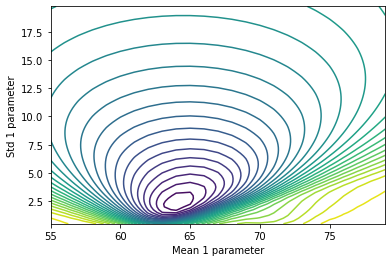

In [38]:
plt.contour(xax3, yax3, np.log(z3), levels=30)
plt.xlabel("Mean 1 parameter")
plt.ylabel("Std 1 parameter")
plt.savefig("2d-mu-sigma.png", dpi=300, bbox_inches="tight")
yax2

In [ ]:
# In this part of the likelihood function, there is a bit of 
# correlation between mu1 and sigma1. 
# Correlations are typical...
# But these have the effect that optimization of one axis at a time
# can be difficult, because the best fit in one direction spoil
# the fit in other directions.

In [ ]:
# Warning:  this is a 2d-plane slice through a 4-dimensional likelihood 
# function, holding mu_2 and sigma_2 constant.  In general, the optimium
# for mu_1 and sigma_1 is going to depend on these, so if I wanted to
# see the "real" joint distribution of mu_1 and sigma_1 I would need
# to find the optimium at each point or marginalize (by numerical 
# integration) to replace mu_2 and sigma_2 with probaiblity-density-informed
# expecatation values.

$$ P_{marginal}(x) = \int dy {P_{posterior}(x|y) P_{prior}(y) }$$

In [39]:
# The two-paramter fit results were
thetahat = [64.08472207,  2.2771205 , 69.42351661,  2.48216295]
# and that was for the function 
yhat = 0.5 * scipy.stats.norm.pdf(x, loc=thetahat[0], scale=thetahat[1]) + 0.5 * scipy.stats.norm.pdf(x, loc=thetahat[2], scale=thetahat[3])

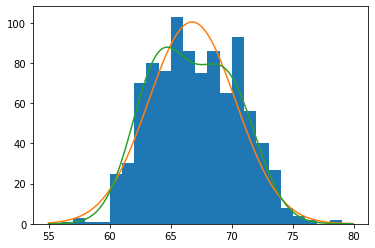

In [40]:
x = np.arange(55,80,.1)
yhat_g = scipy.stats.norm.pdf(x, loc=66.7459, scale=3.577)
plt.hist(y,  bins=np.arange(55, 80))
plt.plot(x,yhat_g *900)
plt.plot(x, yhat*900)

In [ ]:
# So why does the data look like this?  
# Sexual dimorphism.

In [ ]:
galton.head(1)

In [42]:
# Create a column whose value is 1 if gender is male, 0 otherwise: 
galton["indicator"] =  galton.gender == "male"

Text(0.5, 0, 'Child height (in)')

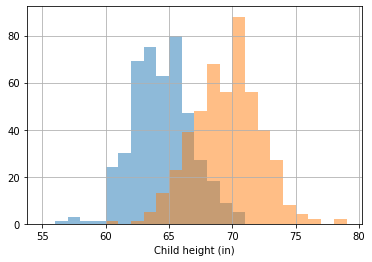

In [43]:
galton.groupby(by="indicator").childHeight.hist(alpha=0.5, bins=np.arange(55, 80))
plt.xlabel("Child height (in)")

In [44]:
# We can get the per-category mean and standard devation

# This goes by the jargon "Class-conditional distribution"
# which is to say, "All the data in class 1"

galton.groupby(by="indicator").childHeight.describe()

,count,mean,std,min,25%,50%,75%,max
indicator,,,,,,,,
False,453.0,64.103974,2.355653,56.0,62.5,64.0,65.5,70.5
True,481.0,69.234096,2.623905,60.0,67.5,69.2,71.0,79.0


In [45]:
# And can write down theoretical densities for normal distributions
# with the empirical mean and standard devation for the two classes:
density1 = scipy.stats.norm.pdf(x, loc=64.103974, scale=2.355653)
density2 = scipy.stats.norm.pdf(x, loc=69.234096, scale=2.623905)

indicator
False    AxesSubplot(0.547727,0.125;0.352273x0.755)
True     AxesSubplot(0.547727,0.125;0.352273x0.755)
Name: childHeight, dtype: object

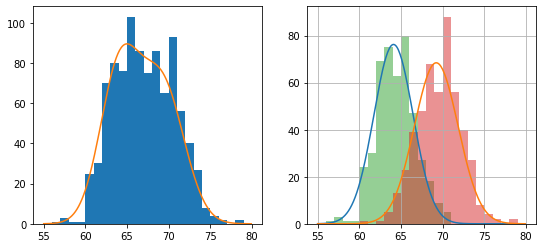

In [46]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.hist(y,  bins=np.arange(55, 80))
plt.plot(x, np.array([(density1+density2)*450 ]).T ) 
plt.subplot(122)
plt.plot(x, np.array([density1*450, density2*450 ]).T ) 
galton.groupby(by="indicator").childHeight.hist(alpha=0.5, bins=np.arange(55, 80))


In [51]:
# The best decision I can make is to pick the most likely class for each 
# value of x
x[np.min(np.where(density1<density2))]

66.70000000000016

In [52]:
# And if I classify everyone shorter than 67.7 as female, 
# this is how my predictions compare to the original labels:
galton["classification"] = galton.childHeight > 67.7 
galton.groupby(["classification", "indicator"]).indicator.count()

classification  indicator
False           False        421
                True         129
True            False         32
                True         352
Name: indicator, dtype: int64

In [53]:

#  Correct: 773    Incorrect:  161 
#  Errors incorrectly classified as M : 32
#         incorrectly classified as F: 129 

len(galton), galton.indicator.sum(), galton.indicator.sum()/len(galton)

(934, 481, 0.5149892933618844)

In [54]:
# overall accuracy, adjusted for nothing:
773/934

0.8276231263383298

Bayes' rule for inferring probability of class $\mathcal{C}_k $  ($k$ is the index that counts $r$ classes) given data $x$: 

$$ P(\mathcal{C}_k | x) \propto {P(x| \mathcal{C}_k) P(\mathcal{C}_k)}  $$

And the probability that $x$ came from class  $\mathcal{C}_1 $ is

$$ P(\mathcal{C}_1 | x) = {P(x| \mathcal{C}_1) P(\mathcal{C}_1) \over 
\displaystyle\sum_{i=1}^r P(x| \mathcal{C}_i) P(\mathcal{C}_i) }  $$


Text(0.5, 0, 'child Height (in)')

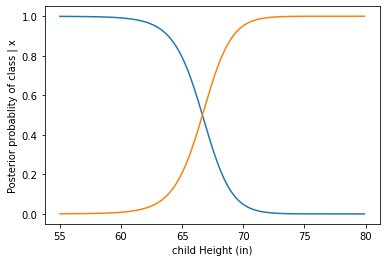

In [55]:
# If I want a graph of my model's posterior probability of being
# in class 1 or class 2 as a function of x: 

p_class1 = density1 /(density1 + density2)
p_class2 = density2 /(density1 + density2)

plt.plot(x,p_class1)
plt.plot(x,p_class2) 
plt.ylabel("Posterior probablity of class | x")
plt.xlabel("child Height (in)")

Text(0.5, 0, 'Child height (in)')

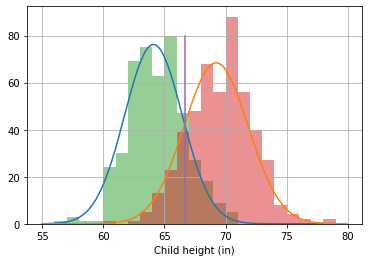

In [56]:
plt.plot(x, np.array([density1*450, density2*450 ]).T ) 
galton.groupby(by="indicator").childHeight.hist(alpha=0.5, bins=np.arange(55, 80))
plt.plot([66.7,66.7], [0,80])
plt.xlabel("Child height (in)")

In [57]:
def find_fpr_fnr(threshold):
    a = galton.query("(indicator == 0) & childHeight <= @threshold").childHeight.count()
    b = galton.query("(indicator == 0) & childHeight > @threshold").childHeight.count()
    c = galton.query("(indicator == 1) & childHeight <= @threshold").childHeight.count()
    d = galton.query("(indicator == 1) & childHeight > @threshold").childHeight.count()
    print(threshold, a,b,c,d)
    return (b / (a+b) , c / (c+d) ) 

In [58]:
find_fpr_fnr(62)

62 102 351 1 480


(0.7748344370860927, 0.002079002079002079)

In [59]:
trange = range(50,80)
fprfnr = np.array([find_fpr_fnr(threshold) for threshold in trange])

50 0 453 0 481
51 0 453 0 481
52 0 453 0 481
53 0 453 0 481
54 0 453 0 481
55 0 453 0 481
56 1 452 0 481
57 3 450 0 481
58 5 448 0 481
59 6 447 0 481
60 24 429 1 480
61 49 404 1 480
62 102 351 1 480
63 172 281 7 474
64 241 212 15 466
65 315 138 35 446
66 379 74 70 411
67 411 42 117 364
68 434 19 174 307
69 445 8 237 244
70 450 3 308 173
71 453 0 381 100
72 453 0 432 49
73 453 0 460 21
74 453 0 472 9
75 453 0 477 4
76 453 0 478 3
77 453 0 479 2
78 453 0 480 1
79 453 0 481 0


1.0 1.0 50
1.0 1.0 51
1.0 1.0 52
1.0 1.0 53
1.0 1.0 54
1.0 1.0 55
0.9977924944812362 1.0 56
0.9933774834437086 1.0 57
0.9889624724061811 1.0 58
0.9867549668874173 1.0 59
0.9470198675496688 0.997920997920998 60
0.891832229580574 0.997920997920998 61
0.7748344370860927 0.997920997920998 62
0.6203090507726269 0.9854469854469854 63
0.46799116997792495 0.9688149688149688 64
0.304635761589404 0.9272349272349272 65
0.16335540838852097 0.8544698544698545 66
0.09271523178807947 0.7567567567567568 67
0.04194260485651214 0.6382536382536382 68
0.017660044150110375 0.5072765072765073 69
0.006622516556291391 0.35966735966735963 70
0.0 0.2079002079002079 71
0.0 0.10187110187110182 72
0.0 0.043659043659043606 73
0.0 0.018711018711018657 74
0.0 0.008316008316008316 75
0.0 0.006237006237006182 76
0.0 0.004158004158004158 77
0.0 0.0020790020790020236 78
0.0 0.0 79


(0.0, 1.0)

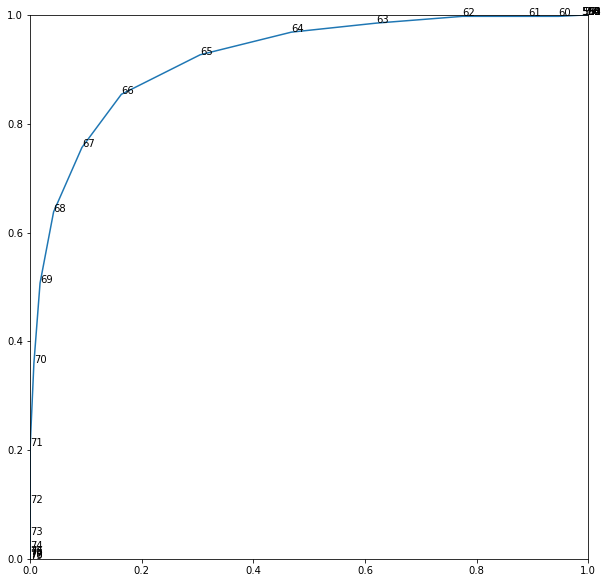

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(fprfnr[:,0], 1-fprfnr[:,1]) 
for x,y,z in zip (fprfnr[:,0], 1-np.array(fprfnr[:,1]) , list(map(str, trange))):
    print (x,y,z)
    ax.text(x, y, z)
plt.xlim([0,1])
plt.ylim([0,1])

1.0 1.0 50
1.0 1.0 51
1.0 1.0 52
1.0 1.0 53
1.0 1.0 54
1.0 1.0 55
0.9977924944812362 1.0 56
0.9933774834437086 1.0 57
0.9889624724061811 1.0 58
0.9867549668874173 1.0 59
0.9470198675496688 0.997920997920998 60
0.891832229580574 0.997920997920998 61
0.7748344370860927 0.997920997920998 62
0.6203090507726269 0.9854469854469854 63
0.46799116997792495 0.9688149688149688 64
0.304635761589404 0.9272349272349272 65
0.16335540838852097 0.8544698544698545 66
0.09271523178807947 0.7567567567567568 67
0.04194260485651214 0.6382536382536382 68
0.017660044150110375 0.5072765072765073 69
0.006622516556291391 0.35966735966735963 70
0.0 0.2079002079002079 71
0.0 0.10187110187110182 72
0.0 0.043659043659043606 73
0.0 0.018711018711018657 74
0.0 0.008316008316008316 75
0.0 0.006237006237006182 76
0.0 0.004158004158004158 77
0.0 0.0020790020790020236 78
0.0 0.0 79


Text(0.5, 0, '')

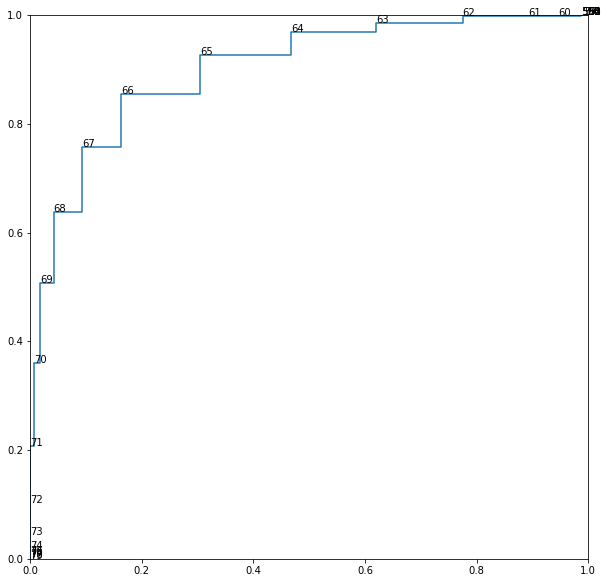

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
plt.step(fprfnr[:,0], 1-fprfnr[:,1]) 
for x,y,z in zip (fprfnr[:,0], 1-np.array(fprfnr[:,1]) , list(map(str, trange))):
    print (x,y,z)
    ax.text(x, y, z)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("")

In [ ]:
find_fpr_fnr(66.7)